PRUEBA

In [1]:
from pycocotools.coco import COCO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
from random import randint

coco_folder = '/mnt/DATASSD/DataSandbox/coco'
dp_coco = COCO( coco_folder + '/annotations/densepose_coco_2014_train.json')

loading annotations into memory...
Done (t=8.29s)
creating index...
index created!


In [2]:
# Get img id's for the minival dataset.
im_ids = dp_coco.getImgIds()
# Select a random image id.
Selected_im = im_ids[randint(0, len(im_ids))] # Choose im no 57 to replicate 
# print(Selected_im)
# Selected_im = 262145
Selected_im = 393224
# Load the image
im = dp_coco.loadImgs(Selected_im)[0]  
# Load Anns for the selected image.
ann_ids = dp_coco.getAnnIds( imgIds=im['id'] )
anns = dp_coco.loadAnns(ann_ids)
# Now read and b
im_name = os.path.join( coco_folder + '/train2014', im['file_name'] )


/mnt/DATASSD/DataSandbox/coco/train2014/COCO_train2014_000000393224.jpg


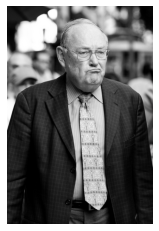

In [3]:
print(im_name)
I=cv2.imread(im_name)
plt.imshow(I[:,:,::-1]); plt.axis('off'); plt.show()

In [4]:
ids = dp_coco.getAnnIds(imgIds=[Selected_im])
print(ids)
target = dp_coco.loadAnns(ids)
print(len(target))
file_name = dp_coco.loadImgs(Selected_im)[0]['file_name']
print(file_name)
mask = dp_coco.annToMask(target[0])
print(mask.shape, mask.max())

[462133, 2026780, 2030491, 2030874, 2032472]
5
COCO_train2014_000000393224.jpg
(640, 427) 1


In [5]:
def GetDensePoseMask(Polys):
    MaskGen = np.zeros([256,256])
    for i in range(1,15):
        if(Polys[i-1]):
            print(Polys[i-1])
            current_mask = mask_util.decode(Polys[i-1])
            print(np.sum(current_mask))
            MaskGen[current_mask>0] = i
    return MaskGen

In [6]:
def GetDensePoseMasks(Polys):
    mask_list = [0]*15
    rle_mask_list = [0]*15
    for i in range(1,15):
        MaskGen = np.zeros([256,256])
        if(Polys[i-1]):
            current_mask = mask_util.decode(Polys[i-1])
            rle_mask = mask_util.encode(current_mask)
            MaskGen[current_mask>0] = 1
        mask_list[i-1] = MaskGen.astype(np.uint8)
        rle_mask_list[i-1] = rle_mask
    return mask_list, rle_mask_list

In [7]:
def get_poligons(mask):
    c = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [0]*2*len(c[0][0].tolist())
    for i,x in enumerate(c[0][0].tolist()):
        contours[2*i]=int(x[0][0])
        contours[2*i+1]= int(x[0][1])
    return contours

In [8]:
def CreateMaskBBox(mask, bbr, image_shape):
    final_mask = np.zeros([image_shape[1],image_shape[0]])
    x1 = int(bbr[0])
    y1 = int(bbr[1])
    x2 = int(bbr[0]+bbr[2])
    y2 = int(bbr[1]+bbr[3])
    x2 = min( [ x2, image_shape[0] ] )
    y2 = min( [ y2, image_shape[1] ] )
    print(bbr, (x1,y1,x2,y2), (int(x2-x1),int(y2-y1)), mask.shape)
    resized_mask = cv2.resize( mask, (int(x2-x1),int(y2-y1)) ,interpolation=cv2.INTER_NEAREST)
    final_mask[y1:y2,x1:x2] = resized_mask
    az = np.nonzero(final_mask)
    bbx1,bbx2,bby1,bby2=np.min(az[0]), np.max(az[0]), np.min(az[1]), np.max(az[1])
    contours = get_poligons(final_mask.astype(np.uint8))
    encoded_final_mask = mask_util.encode(np.asfortranarray(final_mask.astype(np.uint8)))
    mask_area = mask_util.area(encoded_final_mask).astype(np.uint8)
    print((bbx1, bby1, bbx2-bbx1, bby2-bby1),encoded_final_mask)
    encoded_final_mask['counts'] = encoded_final_mask['counts'].decode("utf-8")
    return final_mask, (bbx1, bby1, bbx2-bbx1, bby2-bby1), mask_area, encoded_final_mask, contours

In [9]:
points0 = anns[0]['segmentation'][0]
pointsU = anns[0]['dp_U']
pointsV = anns[0]['dp_V']
pointsx = anns[0]['dp_x']
pointsy = anns[0]['dp_y']


In [10]:
I2 = I.copy()
for i in range(0,len(pointsU)-1,2):
    x = int(pointsU[i])
    y = int(pointsU[i+1])
    I2 = cv2.circle(I2, (x,y), 2,(0,255,0),2)

I3 = I.copy()
for i in range(0,len(pointsU)-1,2):
    x = int(pointsV[i])
    y = int(pointsV[i+1])
    I3 = cv2.circle(I3, (x,y), 2,(0,255,0),2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
{'counts': 'iZ71o7001O0O10000000000O3N2XIN^53]J2a50YJ:b5HWJa0e5_OXJf0f5n0K5L2N4L4L2M6K4L2N4K5L2N4K5L2N5K4L2N4K5L2N4L2M4MO10O100000000O1000000O10000O10000000000O10000O10000000000O10000O1000000O20O2N1O2N1O1O1O2N002N1O1O1O1O001O1O001O00001O00001O0000000000000000000000O100000000000000O10000000000O1000000O1O1O001O1O1O1N2N2O1N2N2001N10001O00001O00001O00001O00001N10001O00001O0000001O001O00001O0000001O00001O0O21NM3I7I7L5H7mLdK[2d4dM_KU2e4iMbKk1f4SN`K`1h4`N]KX1f4gNdKe0g4ZOcK2h4Nf1N10Qh00RU5', 'size': [256, 256]}
24557
{'counts': 'n_?2k73M3L4N2L4L4J6O100000000000000000000000000000000000000000000000000000000000000000000001O000000000000000000000000000000000000000000000000000000000000000000000000004Lc0]OU`k0', 'size': [256, 256]}
2246
{'counts': 'ToS14l7c0]O5K0000000000000000000000000000000O100000000000000000000O10000000000000000000000000000O100000000000000000000000000000000000000000000O1a0

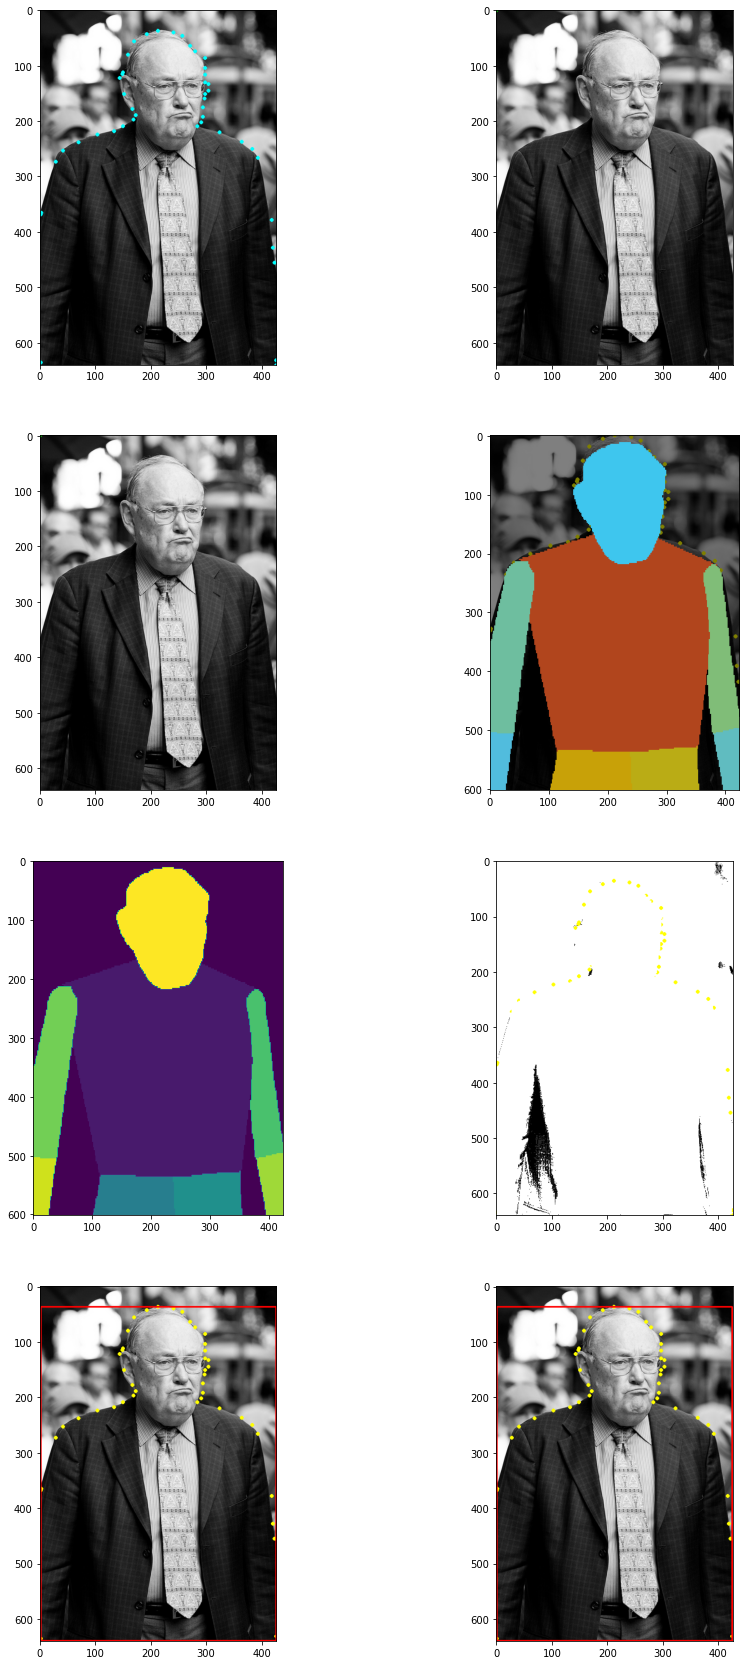

In [11]:

for i in range(0,len(points0),2):
    x = int(points0[i])
    y = int(points0[i+1])
    I = cv2.circle(I, (x,y), 2,(255,255,0),2)
    
I_vis=I.copy()/2 # Dim the image.
I_vis2=I.copy()

# for ann in anns:  
ann = anns[0]
bbr =  np.array(ann['bbox']).astype(int) # the box.
if( 'dp_masks' in ann.keys()): # If we have densepose annotation for this ann, 
    Mask = GetDensePoseMask(ann['dp_masks'])
    mascaras = ann['dp_masks']
    ################
    x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
    print(x1,y1,x2,y2)
    I_vis2 = cv2.rectangle(I_vis2, (x1,y1), (x2,y2),(255,0,0),2)
    x2 = min( [ x2,I.shape[1] ] );  y2 = min( [ y2,I.shape[0] ] )
    ################ 
    print(int(x2-x1),int(y2-y1))
    MaskIm = cv2.resize( Mask, (int(x2-x1),int(y2-y1)) ,interpolation=cv2.INTER_NEAREST)
    MaskBool = np.tile((MaskIm==0)[:,:,np.newaxis],[1,1,3])
    #  Replace the visualized mask image with I_vis.
    Mask_vis = cv2.applyColorMap( (MaskIm*15).astype(np.uint8) , cv2.COLORMAP_PARULA)[:,:,:]
    Mask_vis[MaskBool]=I_vis[y1:y2,x1:x2,:][MaskBool]
    I_vis[y1:y2,x1:x2,:] = I_vis[y1:y2,x1:x2,:]*0.3 + Mask_vis*0.7



'''for i in range(0,len(points1),2):
    x = int(points1[i])
    y = int(points1[i+1])
    I = cv2.circle(I, (x,y), 2,(255,0,255),2)'''

print(I_vis.shape)
fig = plt.figure(figsize=[15,30])
plt.subplot(4,2,1)
plt.imshow(I[:,:,::-1])

plt.subplot(4,2,2)
plt.imshow(I2[:,:,::-1])

plt.subplot(4,2,3)
plt.imshow(I3[:,:,::-1])

plt.subplot(4,2,4)
plt.imshow(Mask_vis)

plt.subplot(4,2,5)
plt.imshow(MaskIm)

plt.subplot(4,2,6)
plt.imshow(I_vis)

plt.subplot(4,2,7)
plt.imshow(I_vis2)

plt.subplot(4,2,8)
plt.imshow(I_vis2)

plt.show()

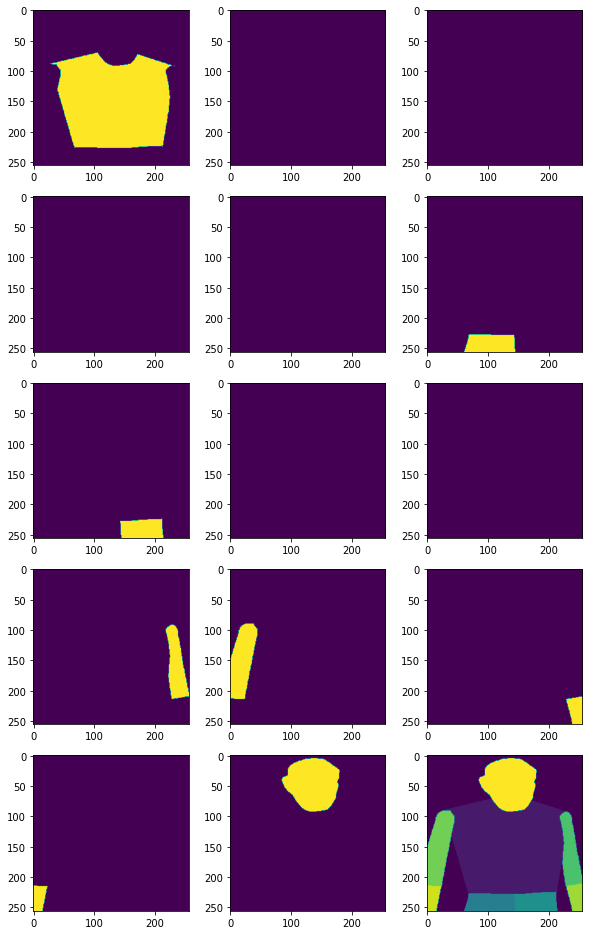

In [12]:
mask_list, rle_mask_list = GetDensePoseMasks(mascaras)
mask_list[14]=Mask
fig = plt.figure(figsize=[10,20])
for i in range(5):
    plt.subplot(6,3,1+i*3)
    plt.imshow(mask_list[i*3])
    plt.subplot(6,3,2+i*3)
    plt.imshow(mask_list[1+i*3])
    plt.subplot(6,3,3+i*3)
    plt.imshow(mask_list[2+i*3])

# plt.subplot(6,3,15)
# plt.imshow(Mask_vis)

plt.show()
    

In [13]:
bbr

array([  1,  37, 424, 602])

In [15]:
final_mask, bound_box, area, encoded_mask, cont = CreateMaskBBox(mask_list[0], bbr, (480, 640, 3) )

[  1  37 424 602] (1, 37, 425, 639) (424, 602) (256, 256)
(204, 50, 369, 335) {'size': [640, 480], 'counts': b'g_o02nc000002N000M3000000000000000000N7K005n^OKo=7eA5Y>KgA5W>0[Ag0Y>YOgAg0Y>]OWAX1`>hNYAd1b>\\N^Ad1b>W2F0M<G5K009G00:F4L0N>D009G5K009G0N<F5K009G0M<G5K00<D009G5K009E<F004L00:F5K0N9I00M3000M300000000000000N2000000000000N200000000M3000000000000000000N200000000N2000000000000000000M300000000N20000000000M6M03M005K2N005K002N2N003M004L00005K002N3M002N002N00003M002N00002N000000003M000000002N00000000000000000000000000000000000000N2000000000000000000000000M3000000000000000000N20000000000N200M300NO1200M300N2N200K500K5N200K500L400002L200000002N000000003M000000002N000000002N000000003K200000002N000000002N00000000003M0000002N000000002N00000000003M000000002N000M3023KI700_Oa000@`0G903\\Oa000gHaDa5Q<]JVDR5T<nJlCR5T<jJ\\DZ4T<fKlCZ4V<aKXDa3[<_LQDn2V<RMjCn2V<PMaDa1Y<]N^D4\\<LdC4\\<Ll303J3000RT31mkL0P`j1'}


In [17]:
cont

[384, 256, 384, 258, 385, 258, 385, 256]

In [20]:
mask_list_final = [0]*15
nbb = [0]*15
conts = [0]*15
for i, mask in enumerate(mask_list):
    if np.sum(mask) > 0:
        mask_list_final[i], nbb[i], area, final_mask, conts[i] = CreateMaskBBox(mask, bbr, (480, 640, 3) )
        print(nbb[i])
    else:
        mask_list_final[i] = None

[  1  37 424 602] (1, 37, 425, 639) (424, 602) (256, 256)
(204, 50, 369, 335) {'size': [640, 480], 'counts': b'g_o02nc000002N000M3000000000000000000N7K005n^OKo=7eA5Y>KgA5W>0[Ag0Y>YOgAg0Y>]OWAX1`>hNYAd1b>\\N^Ad1b>W2F0M<G5K009G00:F4L0N>D009G5K009G0N<F5K009G0M<G5K00<D009G5K009E<F004L00:F5K0N9I00M3000M300000000000000N2000000000000N200000000M3000000000000000000N200000000N2000000000000000000M300000000N20000000000M6M03M005K2N005K002N2N003M004L00005K002N3M002N002N00003M002N00002N000000003M000000002N00000000000000000000000000000000000000N2000000000000000000000000M3000000000000000000N20000000000N200M300NO1200M300N2N200K500K5N200K500L400002L200000002N000000003M000000002N000000002N000000003K200000002N000000002N00000000003M0000002N000000002N00000000003M000000002N000M3023KI700_Oa000@`0G903\\Oa000gHaDa5Q<]JVDR5T<nJlCR5T<jJ\\DZ4T<fKlCZ4V<aKXDa3[<_LQDn2V<RMjCn2V<PMaDa1Y<]N^D4\\<LdC4\\<Ll303J3000RT31mkL0P`j1'}
(204, 50, 369, 335)
[  1  37 424 602] (1, 37, 425, 639) (424, 602) (256, 256)
(571, 103, 67, 1

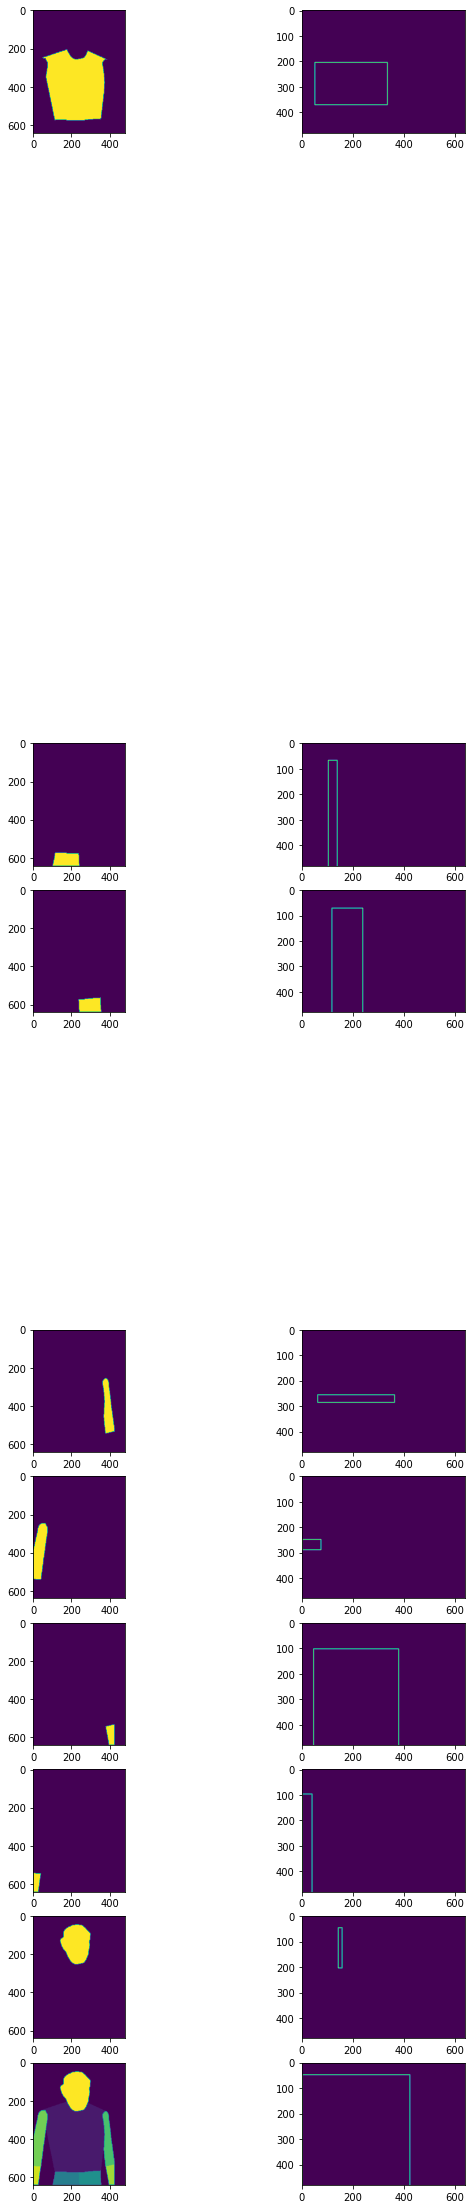

In [21]:
fig = plt.figure(figsize=[10,40])
for i in range(15):
    img_blank = np.zeros((480, 640))
    if mask_list_final[i] is not None: 
        img_blank = cv2.rectangle(img_blank, (nbb[i][1],nbb[i][0]), (nbb[i][3],nbb[i][2]), (255,255,0),2 )
        plt.subplot(15,2,i*2+1)
        plt.imshow(mask_list_final[i])
        plt.subplot(15,2,i*2+2)
        plt.imshow(img_blank)


plt.show()

In [22]:
mask_util.area(rle_mask_list[0])

24557

In [23]:
print(anns[3])

{'segmentation': [[8.25, 198.12, 0, 174.78, 6.7, 146.24, 24.34, 130.16, 67.4, 143.65, 72.07, 151.95, 68.95, 174.78, 32.12, 176.33]], 'num_keypoints': 4, 'area': 2884.0424, 'iscrowd': 0, 'keypoints': [39, 192, 1, 57, 180, 1, 21, 181, 2, 0, 0, 0, 1, 176, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'image_id': 393224, 'bbox': [0, 130.16, 72.07, 67.96], 'category_id': 1, 'id': 2030874}


In [29]:
print(conts)

[[384, 256, 384, 258, 385, 258, 385, 256], 0, 0, 0, 0, [116, 571, 116, 573, 115, 574, 114, 574, 114, 587, 113, 588, 112, 588, 112, 596, 111, 597, 111, 606, 110, 607, 109, 607, 109, 610, 108, 611, 107, 611, 107, 620, 106, 621, 106, 627, 105, 628, 104, 628, 104, 634, 103, 635, 103, 638, 241, 638, 241, 628, 240, 628, 239, 627, 239, 583, 238, 583, 237, 582, 237, 574, 175, 574, 174, 573, 174, 571], [351, 564, 351, 566, 350, 567, 313, 567, 313, 568, 312, 569, 288, 569, 288, 570, 287, 571, 270, 571, 270, 573, 269, 574, 238, 574, 238, 582, 239, 582, 240, 583, 240, 627, 241, 627, 242, 628, 242, 638, 355, 638, 355, 628, 354, 628, 353, 627, 353, 604, 352, 603, 352, 564], 0, 0, [376, 256, 376, 258, 375, 259, 372, 259, 372, 260, 371, 261, 371, 262, 370, 263, 368, 263, 368, 265, 367, 266, 366, 266, 366, 269, 365, 270, 363, 270, 363, 286, 364, 287, 364, 293, 365, 293, 366, 294, 366, 305, 367, 305, 368, 306, 368, 316, 369, 317, 369, 328, 370, 328, 371, 329, 371, 349, 372, 350, 372, 370, 373, 370, 374,

In [35]:
print(conts[1])

0


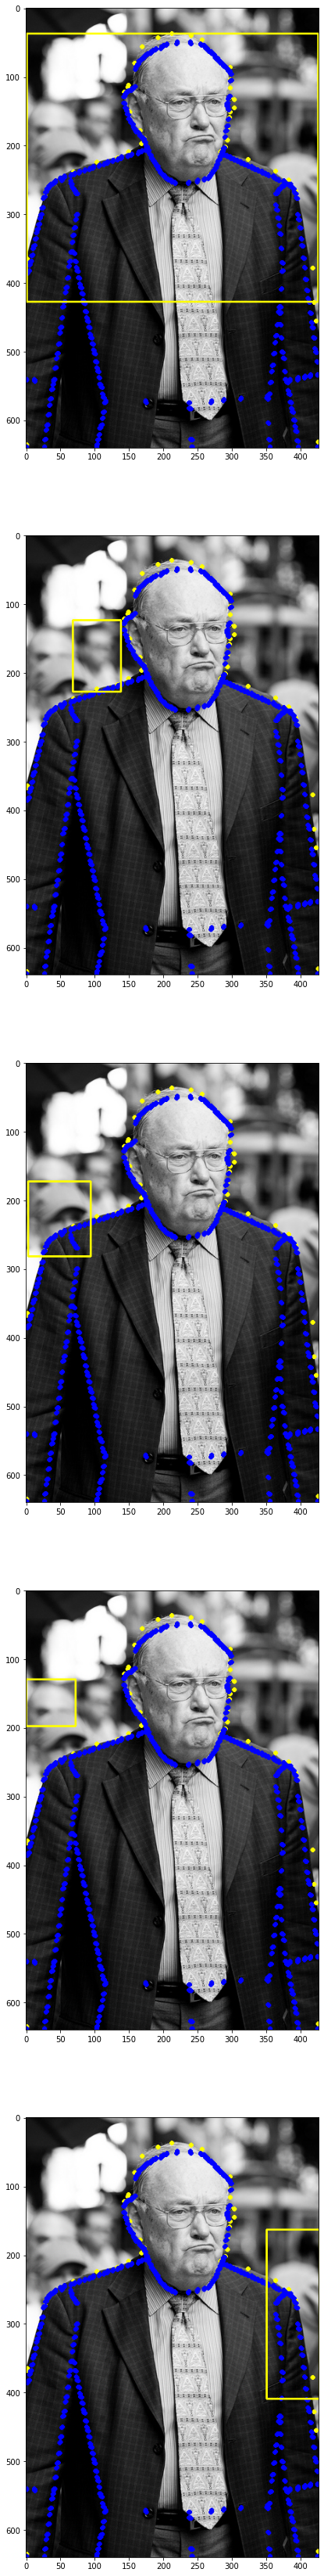

In [38]:
n = len(anns)
fig = plt.figure(figsize=[60,60])
i = 1
img = I.copy()

for cont in conts:
    if type(cont)==list:
        for j in range(0,len(cont),2):
            xx = cont[j]
            yy = cont[j+1]
            I = cv2.circle(I, (xx,yy),2,(0,0,255),2)

for ann in anns:
    img = I.copy()
    bbr = ann['bbox']
    x1 = int(bbr[0])
    y1 = int(bbr[1])
    x2 = int(bbr[0]+bbr[2])
    y2 = int(bbr[1]+bbr[3])
    x2 = min( [ x2, 640 ] )
    y2 = min( [ y2, 427 ] )
    img = cv2.rectangle(img, (x1,y1), (x2,y2), (255,255,0),2 )
    plt.subplot(n,1,i)
    plt.imshow(img)
    i += 1

plt.show()